In [2]:
import pandas as pd
from datetime import datetime
start_time = datetime.now()

# libraries needed to install
# %pip install pandas-profiling
# %pip install pydot
# %pip install pydotplus
# %conda install python-graphviz
# %pip install plotly

import pandas_profiling
import scipy.stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import Patch
import matplotlib
from sklearn.ensemble import IsolationForest
from sklearn.tree import export_graphviz
from io import StringIO  
from IPython.core.pylabtools import figsize
from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import plotly.offline as py
import pydot
import pydotplus
import graphviz
%matplotlib inline

print('LOADING DURATION: ', datetime.now() - start_time) # about two minutes

LOADING DURATION:  0:00:01.694405


## Data Imputation

In [3]:
data = pd.read_csv('supermarket.csv')
data.shape

(60366, 40)

In [4]:
# Return data memory usage, if desired
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # assume series otherwise
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to MB
    return "{:03.2f} MB".format(usage_mb)

print(mem_usage(data))

18.42 MB


In [4]:
# profile = pandas_profiling.ProfileReport(data)
# profile.to_file('data report.html')

In [17]:
data['avg_purchase_capped']=data['avg_purchase'].clip(upper=20)

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning:

invalid value encountered in greater_equal

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning:

invalid value encountered in less_equal



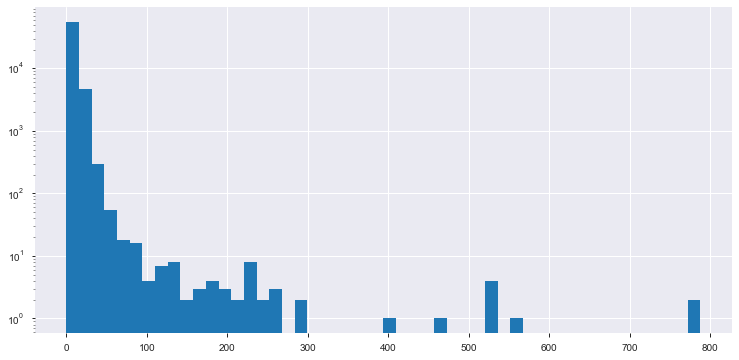

In [6]:
figsize(12.5,6)
# Uncapped, a significant portion of the data run large. 
plt.hist(data['avg_purchase'],bins=50) # Output RuntimeWarning due to NaN values in bins. 
plt.yscale('log')

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning:

invalid value encountered in greater_equal

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning:

invalid value encountered in less_equal



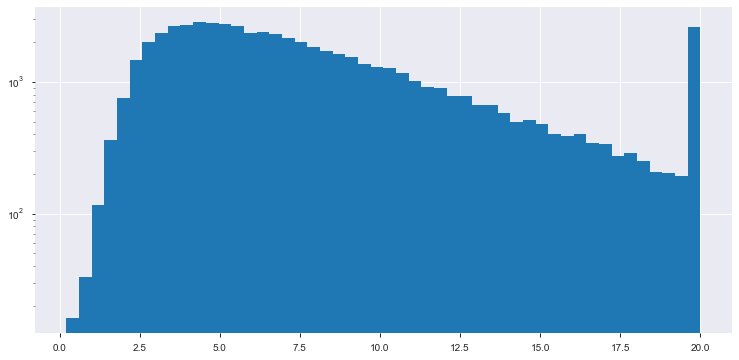

In [7]:
# When capped at $20, the distribution becomes much more smooth. 
plt.hist(data['avg_purchase_capped'],bins=50)
plt.yscale('log')

In [13]:
# Summary statistics
summary = pd.DataFrame(index = data.columns)
summary['Data type'] = data.dtypes.values
summary['# Nonnull records'] = data.count().values
summary['# Non-zero records'] = data.astype(bool).sum(axis=0)
summary['% Populated'] = round(data.count()/data.shape[0]*100,2)
summary['# Unique values'] = data.nunique().values
summary['Mean'] = round(data.mean(),2)
summary['Std'] = round(data.std(),2)
summary['Min'] = round(data.min(),2)
summary['Max'] = round(data.max(),2)
summary

Data type  # Nonnull records  \
customer_id                          int64              60366   
avg_distance_to_shops              float64              60365   
min_distance_to_shops              float64              60365   
max_distance_to_shops              float64              60365   
products_purchased                 float64              60365   
unique_products_purchased          float64              60365   
amount_purchased                   float64              60365   
avg_purchase                       float64              60365   
avg_price                          float64              60365   
shops_used                         float64              60365   
distance_shop_1                    float64              60366   
distance_shop_2                    float64              60366   
distance_shop_3                    float64              60366   
distance_shop_4                    float64              60366   
distance_shop_5                    float64              60366   
products_purchased_shop_1            int64              60366   
products_purchased_shop_2            int64              60366   
products_purchased_shop_3            int64              60366   
products_purchased_shop_4            int64              60366   
products_purchased_shop_5            int64              60366   
unique_products_purchased_shop_1     int64              60366   
unique_products_purchased_shop_2     int64              60366   
unique_products_purchased_shop_3     int64              60366   
unique_products_purchased_shop_4     int64              60366   
unique_products_purchased_shop_5     int64              60366   
amount_purchased_shop_1            float64              60366   
amount_purchased_shop_2            float64              60366   
amount_purchased_shop_3            float64              60366   
amount_purchased_shop_4            float64              60366   
amount_purchased_shop_5            float64              60366   
avg_purchase_shop_1                float64              60366   
avg_purchase_shop_2                float64              60366   
avg_purchase_shop_3                float64              60366   
avg_purchase_shop_4                float64              60366   
avg_purchase_shop_5                float64              60366   
avg_price_shop_1                   float64              60366   
avg_price_shop_2                   float64              60366   
avg_price_shop_3                   float64              60366   
avg_price_shop_4                   float64              60366   
avg_price_shop_5                   float64              60366   
avg_purchase_capped                float64              60365   

                                  # Non-zero records  % Populated  \
customer_id                                    60366        100.0   
avg_distance_to_shops                          60366        100.0   
min_distance_to_shops                          60366        100.0   
max_distance_to_shops                          60366        100.0   
products_purchased                             60366        100.0   
unique_products_purchased                      60366        100.0   
amount_purchased                               60366        100.0   
avg_purchase                                   60366        100.0   
avg_price                                      60366        100.0   
shops_used                                     60366        100.0   
distance_shop_1                                60366        100.0   
distance_shop_2                                60366        100.0   
distance_shop_3                                60366        100.0   
distance_shop_4                                60366        100.0   
distance_shop_5                                60366        100.0   
products_purchased_shop_1                      55552        100.0   
products_purchased_shop_2                      44794        100.0   
products_purchased_shop_3                      20503        

In [14]:
data.fillna(0, inplace=True)
# cols = cols[1:]
# for col in cols:
#     plt.hist(data[col],bins=50)
#     plt.xlabel(col)
#     plt.show()

In [15]:
cormat = data.corr(method='pearson')
cormat.style.background_gradient(cmap='coolwarm').set_precision(2)

In [16]:
#  an easier to examine correlation matrix

correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data_corr = [trace]
fig = go.Figure(data=data_corr,layout=layout)
py.iplot(fig)

## Customer Segmentation

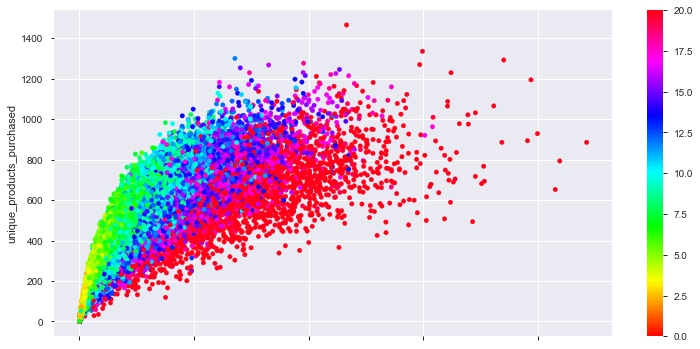

In [18]:
# Two possible choices of dimensions for segmentation. Use one or the other.

# choice 1:
x1_axis = 'products_purchased'
x2_axis = 'unique_products_purchased'
Y_column = 'avg_purchase_capped'

# choice 2:
# x1_axis = 'min_distance_to_shops'
# x2_axis = 'max_distance_to_shops'
# Y_column = 'amount_purchased'

X = data[[x1_axis,x2_axis]]
Y = data[[Y_column]]

# always z scale before clustering
Xz = (X-X.mean()) / X.std()
X.plot.scatter(x1_axis, x2_axis, cmap = 'hsv', c = data[Y_column])
plt.savefig('customer scatter.png')

In [19]:
Y.describe()

avg_purchase_capped
count         60366.000000
mean              8.056039
std               4.633757
min               0.000000
25%               4.532746
50%               6.862588
75%              10.429527
max              20.000000

In [20]:
X.describe()

products_purchased  unique_products_purchased
count        60366.000000               60366.000000
mean          1778.682918                 330.662707
std           2185.044967                 236.006225
min              0.000000                   0.000000
25%            227.000000                 127.000000
50%            925.000000                 304.000000
75%           2551.750000                 500.000000
max          22131.000000                1465.000000

In [21]:
Xz.describe()

products_purchased  unique_products_purchased
count        6.036600e+04               6.036600e+04
mean         1.830104e-16               1.312088e-16
std          1.000000e+00               1.000000e+00
min         -8.140258e-01              -1.401076e+00
25%         -7.101378e-01              -8.629548e-01
50%         -3.906935e-01              -1.129746e-01
75%          3.537992e-01               7.175120e-01
max          9.314370e+00               4.806387e+00

### Select the number of segments(clusters)

In [22]:
# Performs KMeans clustering, and select maximum cluster number which satisfies silhouette score of >= 0.48.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

matrix = Xz.values

for n in range(4,9):
#     kmeans = KMeans(init='k-means++', n_clusters = n, n_init=30, n_jobs=-1) # n_jobs deprecated in version 0.23.
    kmeans = KMeans(init='k-means++', n_clusters = n, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    centroids = kmeans.cluster_centers_
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For # clusters =", n, "the average silhouette_score is :", silhouette_avg)
    
    if silhouette_avg >= 0.48: 
        num_clusters = n

print("The chosen # of clusters is ", num_clusters)

For # clusters = 4 the average silhouette_score is : 0.5199505400423561
For # clusters = 5 the average silhouette_score is : 0.4970538466753029
For # clusters = 6 the average silhouette_score is : 0.4818696713176349
For # clusters = 7 the average silhouette_score is : 0.46386137722102144
For # clusters = 8 the average silhouette_score is : 0.44667599363840316
The chosen # of clusters is  6


### Decision Tree Clustering

In [23]:
clf = DecisionTreeRegressor(max_depth=7,max_leaf_nodes=6,min_samples_leaf=3000) # Change the max_leaf_node from 8 to 5
        
clf.fit(X, Y)
goodness = clf.score(X,Y)
print(goodness)

0.6009013157142429


In [24]:
# put the cluster label as the final leaf. Note these cluster lables aren't sequential

data['DT_cluster'] = clf.apply(X)
data.head()

customer_id  avg_distance_to_shops  min_distance_to_shops  \
0            1             1434.91910              985.87620   
1            2              909.76764              254.94832   
2            3             1498.94700              754.29560   
3            4              561.65900              362.79178   
4            5              605.36280              275.46753   

   max_distance_to_shops  products_purchased  unique_products_purchased  \
0              4082.5222              3090.0                      473.0   
1              2295.4840              4508.0                      486.0   
2              2831.7727               814.0                      234.0   
3              2210.3820               648.0                      208.0   
4              1375.1184                13.0                       10.0   

   amount_purchased  avg_purchase  avg_price  shops_used  ...  \
0          7551.701     14.221659   3.150493         2.0  ...   
1          7820.219     11.235947   2.191422         4.0  ...   
2          1788.613      5.453088   2.258994         4.0  ...   
3          1679.520      5.976940   2.614292         4.0  ...   
4            17.922      1.792200   1.692000         2.0  ...   

   avg_purchase_shop_3  avg_purchase_shop_4  avg_purchase_shop_5  \
0             0.000000                  0.0             0.000000   
1             2.546600                  0.0            16.479185   
2             1.923385                  0.0             5.924268   
3             5.029184                  0.0             7.156351   
4             2.145571                  0.0             0.000000   

   avg_price_shop_1  avg_price_shop_2  avg_price_shop_3  avg_price_shop_4  \
0          6.393403          2.600485          0.000000               0.0   
1          2.851152          2.009863          2.059450               0.0   
2          3.426687          2.478529          1.923385               0.0   
3          4.997400          2.688400          2.083168               0.0   
4          0.000000          0.633667          2.145571               0.0   

   avg_price_shop_5  avg_purchase_capped  DT_cluster  
0          0.000000            14.221659           7  
1          2.103394            11.235947           7  
2          1.947067             5.453088           3  
3          2.754427             5.976940           3  
4          0.000000             1.792200           3  

[5 rows x 42 columns]

In [25]:
data['DT_cluster'].value_counts()

3     30430
4     14405
6      5437
10     3538
9      3534
7      3022
Name: DT_cluster, dtype: int64

In [26]:
groupDT = data.groupby('DT_cluster',as_index=False)[['products_purchased','unique_products_purchased']].mean()
groupDT.sort_values('products_purchased')

DT_cluster  products_purchased  unique_products_purchased
0           3          308.772560                 141.019224
1           4         1613.162444                 410.958417
4           9         3066.637238                 609.450764
3           7         3274.335539                 434.877895
5          10         4285.333522                 658.111080
2           6         7144.449329                 727.113666

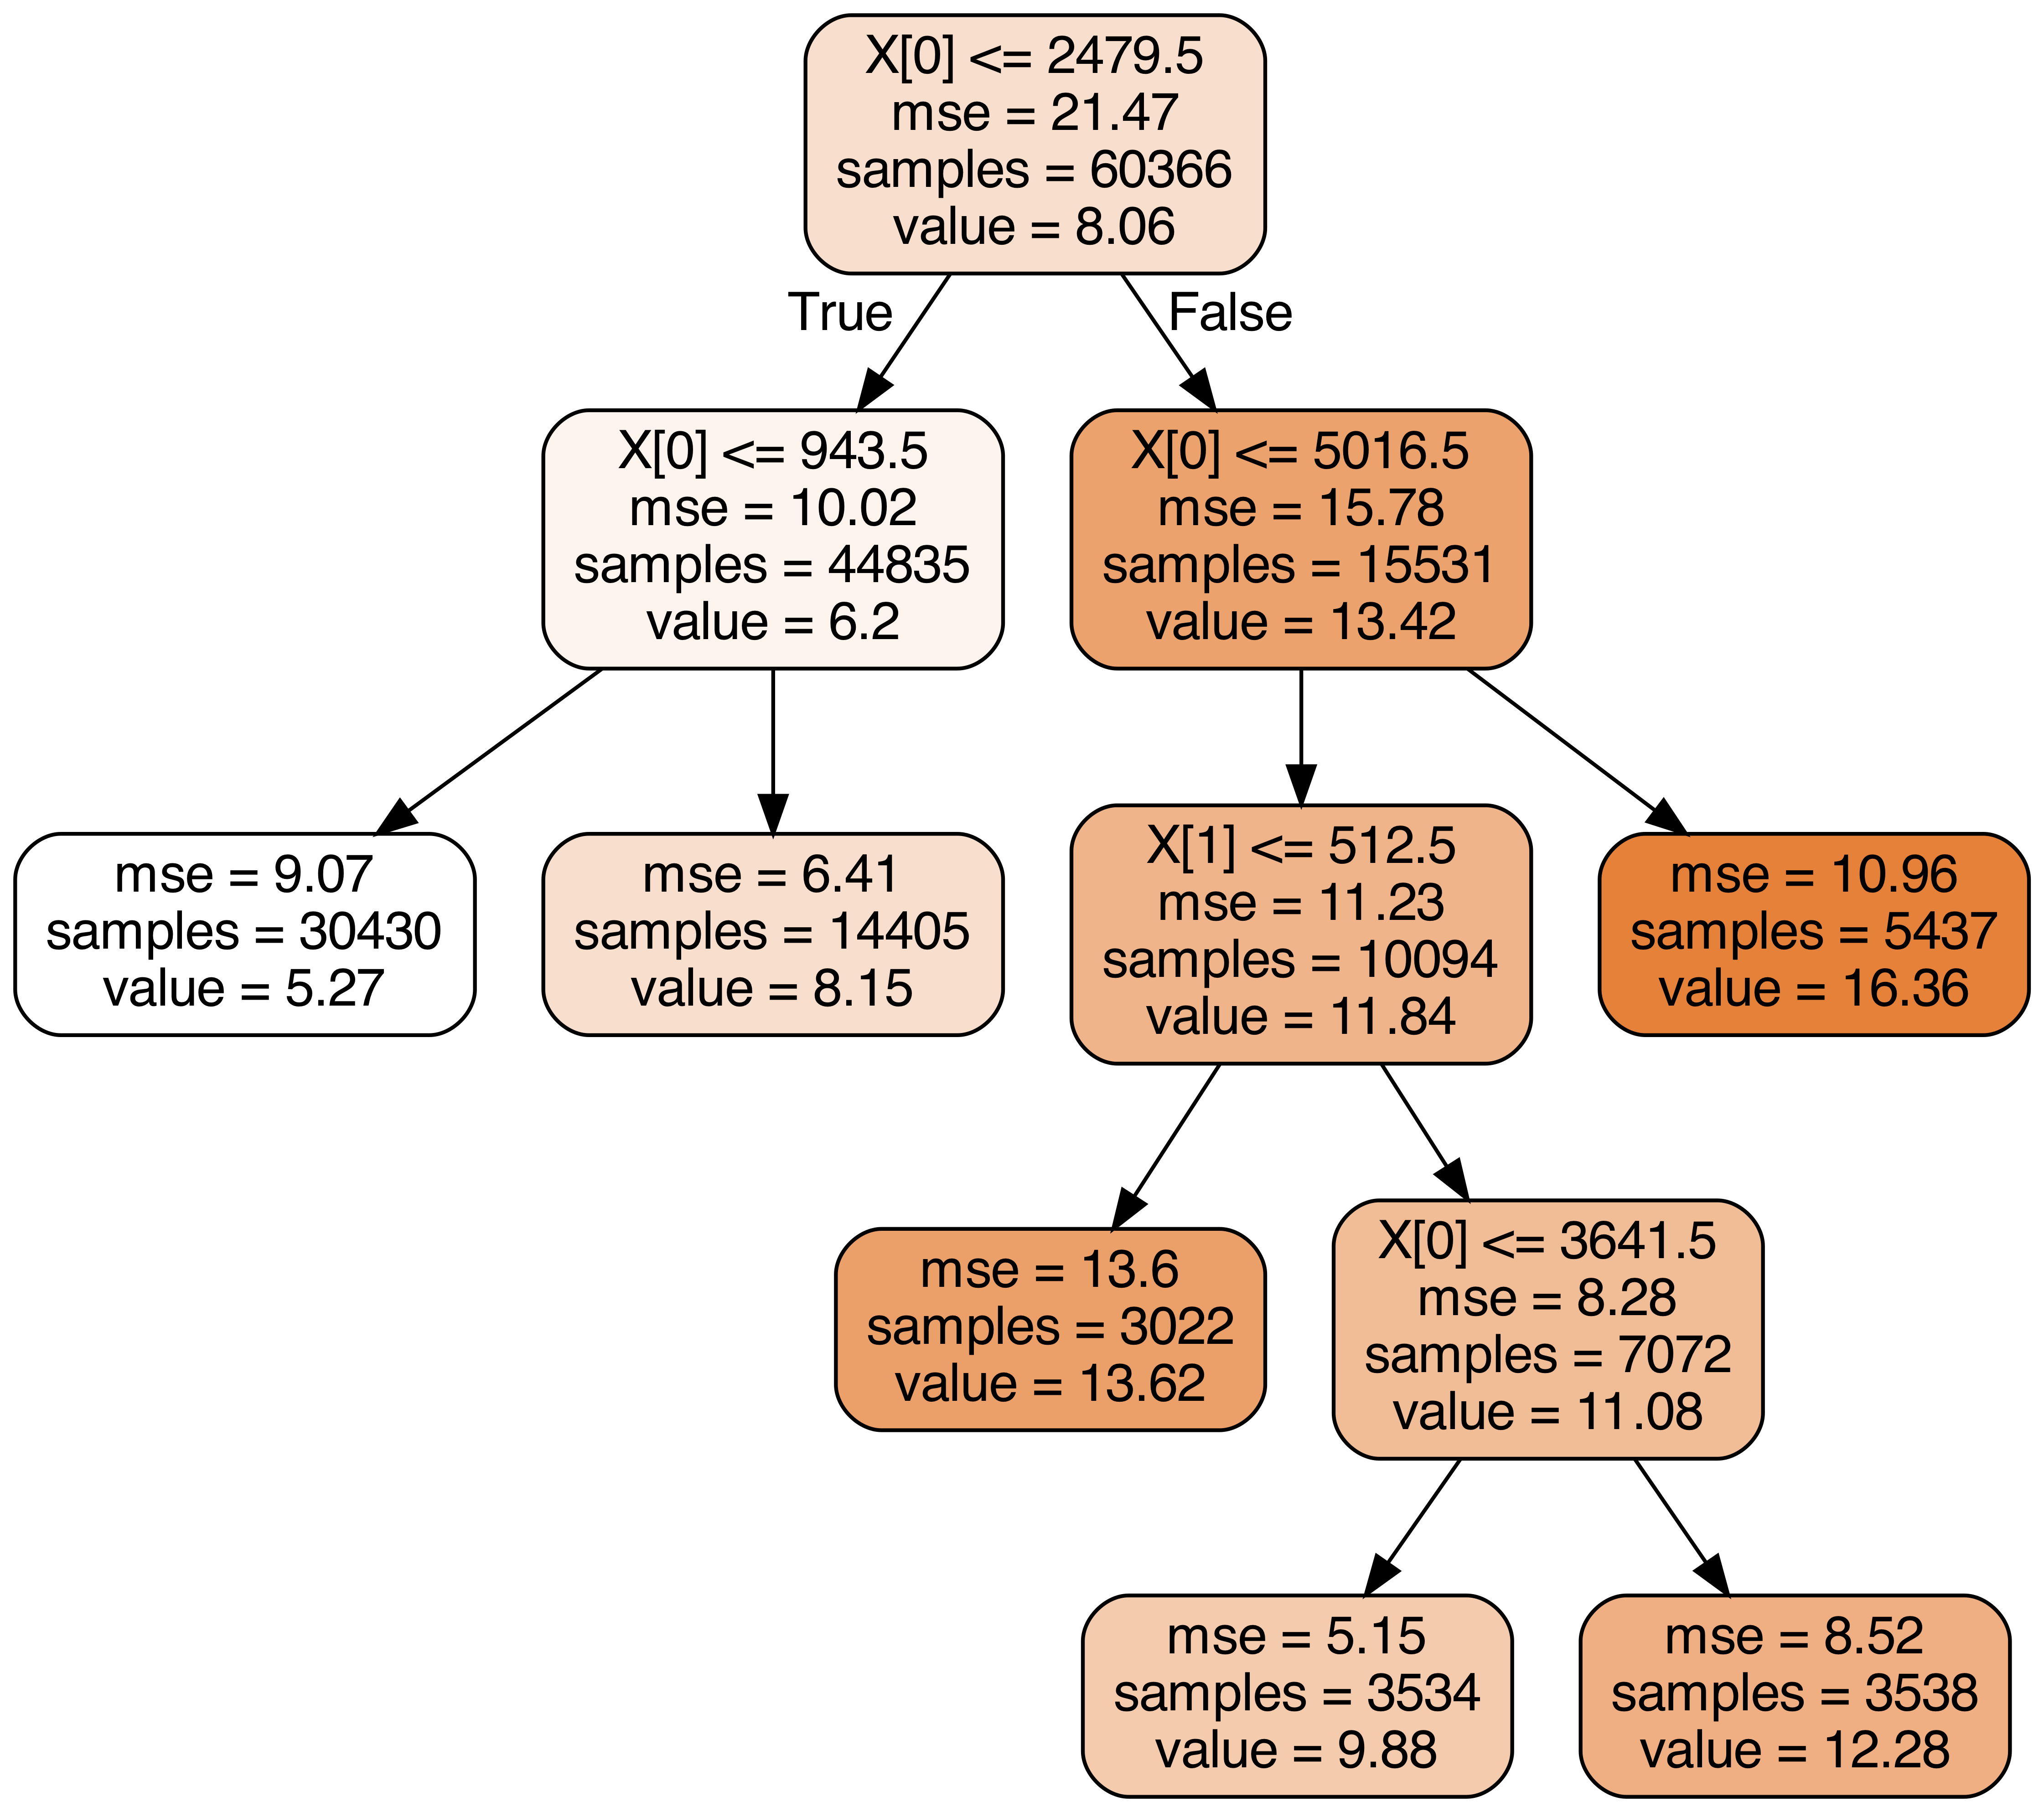

In [27]:
# if number of leaves is very high then comment out this cell

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
            filled=True, rounded=True,
            special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
# Export as dot file
export_graphviz(clf, out_file='tree.dot', 
            rounded = True, proportion = False, 
            precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in notebook
from IPython.display import Image
Image(filename = 'tree.png')

<Figure size 1224x504 with 0 Axes>

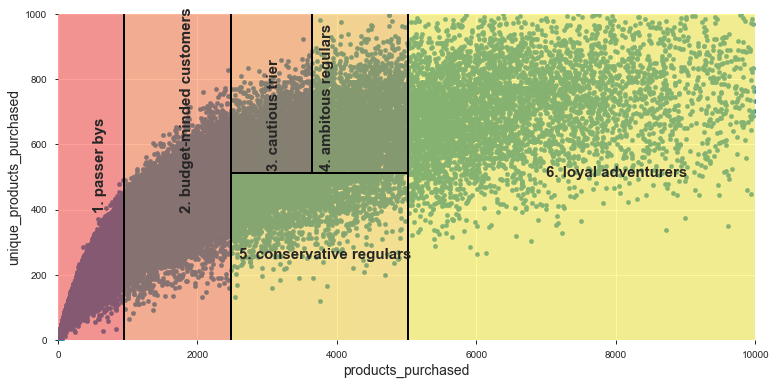

In [28]:
from matplotlib.colors import ListedColormap
x1_high = 10000
x2_high = 1000

def plot_decision_boundary(clf, X, y, axes=[0, x1_high, 0, x2_high]):
    x1s = np.linspace(axes[0], axes[1], 500)
    x2s = np.linspace(axes[2], axes[3], 500)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
# other cmap to try: gray, spring, summer, afmhot, hot, gist_heat, winter...
    plt.contourf(x1, x2, y_pred, alpha=0.4, cmap='autumn')
    plt.xlabel(x1_axis, fontsize=14)
    plt.ylabel(x2_axis, fontsize=14)
    plt.plot([2479.5, 2479.5], [0, x2_high], "k-", linewidth=2)
    plt.plot([943.5,943.5],[0,x2_high],"k-",linewidth =2)
    plt.plot([5016.5,5016.5],[0,x2_high],"k-",linewidth =2)
    plt.plot([2479.5,5016.5],[512.5,512.5],"k-",linewidth =2)
    plt.plot([3641.5,3641.5],[512.5,x2_high],"k-",linewidth = 2)
    plt.text(500,400,"1. passer bys ",fontsize=15,rotation='vertical',weight='bold')
    plt.text(1750,400,"2. budget-minded customers",fontsize=15,rotation='vertical',weight='bold')
    plt.text(3000,530,"3. cautious trier",fontsize=15,rotation='vertical',weight='bold')
    plt.text(3750,530,"4. ambitous regulars",fontsize=15,rotation='vertical',weight='bold')
    plt.text(2600,250,"5. conservative regulars",fontsize=15,weight='bold')
    plt.text(7000,500,"6. loyal adventurers",fontsize=15,weight='bold')
plt.figure(figsize=(17, 7))
X1 = X[X[x1_axis] <= x1_high]
Xsmall = X1[X1[x2_axis] <= x2_high]
Xsmall.plot.scatter(x1_axis,x2_axis)
plt.xlim(0,x1_high)
plt.ylim(0,x2_high)

plot_decision_boundary(clf, X, Y)
plt.savefig('Decision Tree Segments.png')

### K-means Clustering

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
matrix = Xz.values
for n in range(6,7):
    kmeans = KMeans(init='k-means++', n_clusters = n, n_init=30, n_jobs=-1)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    centroids = kmeans.cluster_centers_
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For # clusters =", n, "the average silhouette_score is :", silhouette_avg)

num_clusters = n

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.



For # clusters = 6 the average silhouette_score is : 0.4827343103205956


In [30]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
#     plt.rcParams["patch.force_edgecolor"] = True
    import matplotlib as mpl
    import matplotlib.cm as cm
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

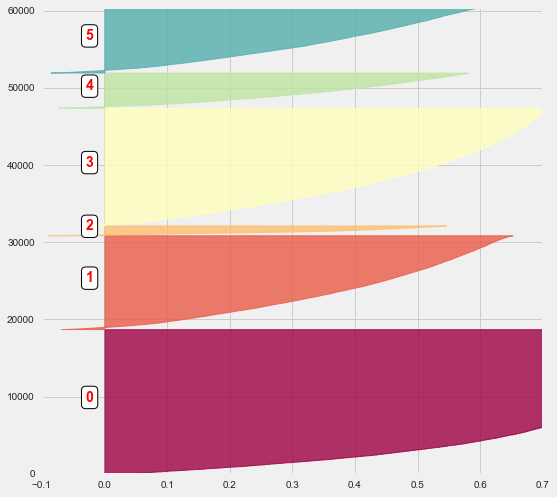

In [31]:
# show individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(num_clusters, [-0.1, .7], len(X), sample_silhouette_values, clusters)
plt.savefig('silouhette scores.pdf')

In [32]:
pd.DataFrame(pd.Series(clusters).value_counts(), columns = ['# customers']).T

0      3      1     5     4     2
# customers  18727  15228  12153  8446  4551  1261

In [33]:
print(centroids)

[[-0.75497487 -1.09564086]
 [ 0.04442034  0.45567747]
 [ 3.85122929  2.03639257]
 [-0.4693356  -0.29510528]
 [ 1.95382858  1.68340206]
 [ 0.83260352  1.10360059]]


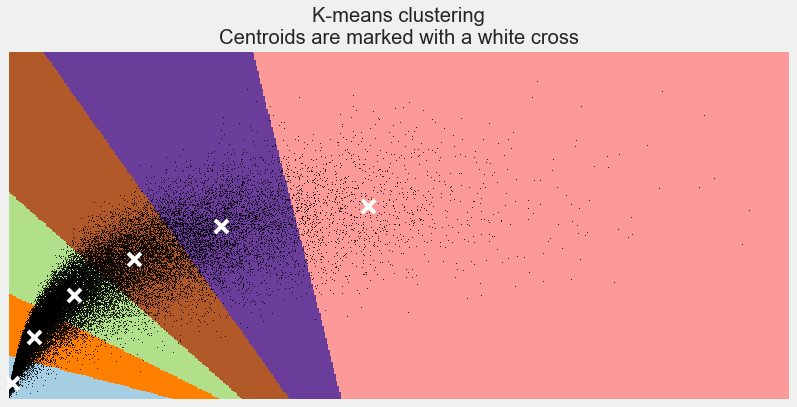

In [34]:
# Visualize the results

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = matrix[:, 0].min(), matrix[:, 0].max()
y_min, y_max = matrix[:, 1].min(), matrix[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(matrix[:, 0], matrix[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering\n'
          'Centroids are marked with a white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.savefig('kmeans segmentation.png')
plt.show()

In [35]:
data['Knn_cluster'] = clusters
data.head(10)

customer_id  avg_distance_to_shops  min_distance_to_shops  \
0            1             1434.91910              985.87620   
1            2              909.76764              254.94832   
2            3             1498.94700              754.29560   
3            4              561.65900              362.79178   
4            5              605.36280              275.46753   
5            6             2603.69560             1972.48940   
6            7             2068.84280             2068.84280   
7            8             1399.30570              245.44533   
8            9             1789.29030              164.82315   
9           10             1940.03210              968.77356   

   max_distance_to_shops  products_purchased  unique_products_purchased  \
0              4082.5222              3090.0                      473.0   
1              2295.4840              4508.0                      486.0   
2              2831.7727               814.0                      234.0   
3              2210.3820               648.0                      208.0   
4              1375.1184                13.0                       10.0   
5              3697.2300              2783.0                      620.0   
6              2068.8428                20.0                       19.0   
7              1679.8247              2601.0                      322.0   
8              3199.9387              7977.0                      743.0   
9              2437.8691              3810.0                      552.0   

   amount_purchased  avg_purchase  avg_price  shops_used  ...  \
0          7551.701     14.221659   3.150493         2.0  ...   
1          7820.219     11.235947   2.191422         4.0  ...   
2          1788.613      5.453088   2.258994         4.0  ...   
3          1679.520      5.976940   2.614292         4.0  ...   
4            17.922      1.792200   1.692000         2.0  ...   
5          6346.385      7.059382   2.785088         4.0  ...   
6            47.157      2.481947   2.355105         1.0  ...   
7          6939.357     18.071241   2.983021         3.0  ...   
8         17245.062     15.777733   3.072187         2.0  ...   
9          8434.010     11.553438   2.552993         3.0  ...   

   avg_purchase_shop_4  avg_purchase_shop_5  avg_price_shop_1  \
0                  0.0             0.000000          6.393403   
1                  0.0            16.479185          2.851152   
2                  0.0             5.924268          3.426687   
3                  0.0             7.156351          4.997400   
4                  0.0             0.000000          0.000000   
5                  0.0             1.984538          3.349176   
6                  0.0             0.000000          2.355105   
7                  0.0             0.000000          5.227889   
8                  0.0             0.000000          3.339414   
9                  0.0             0.000000          2.632964   

   avg_price_shop_2  avg_price_shop_3  avg_price_shop_4  avg_price_shop_5  \
0          2.600485          0.000000               0.0          0.000000   
1          2.009863          2.059450               0.0          2.103394   
2          2.478529          1.923385               0.0          1.947067   
3          2.688400          2.083168               0.0          2.754427   
4          0.633667          2.145571               0.0          0.000000   
5          2.525061          2.082261               0.0          1.914615   
6          0.000000          0.000000               0.0          0.000000   
7          2.965092          2.507716               0.0          0.000000   
8          2.764455          0.000000               0.0          0.000000   
9          2.521915          0.334000               0.0          0.000000   

   avg_purchase_capped  DT_cluster  Knn_cluster  
0            14.221659           7            5  
1            11.235947           7            5  
2             5.453088           3        

## Segment Analysis

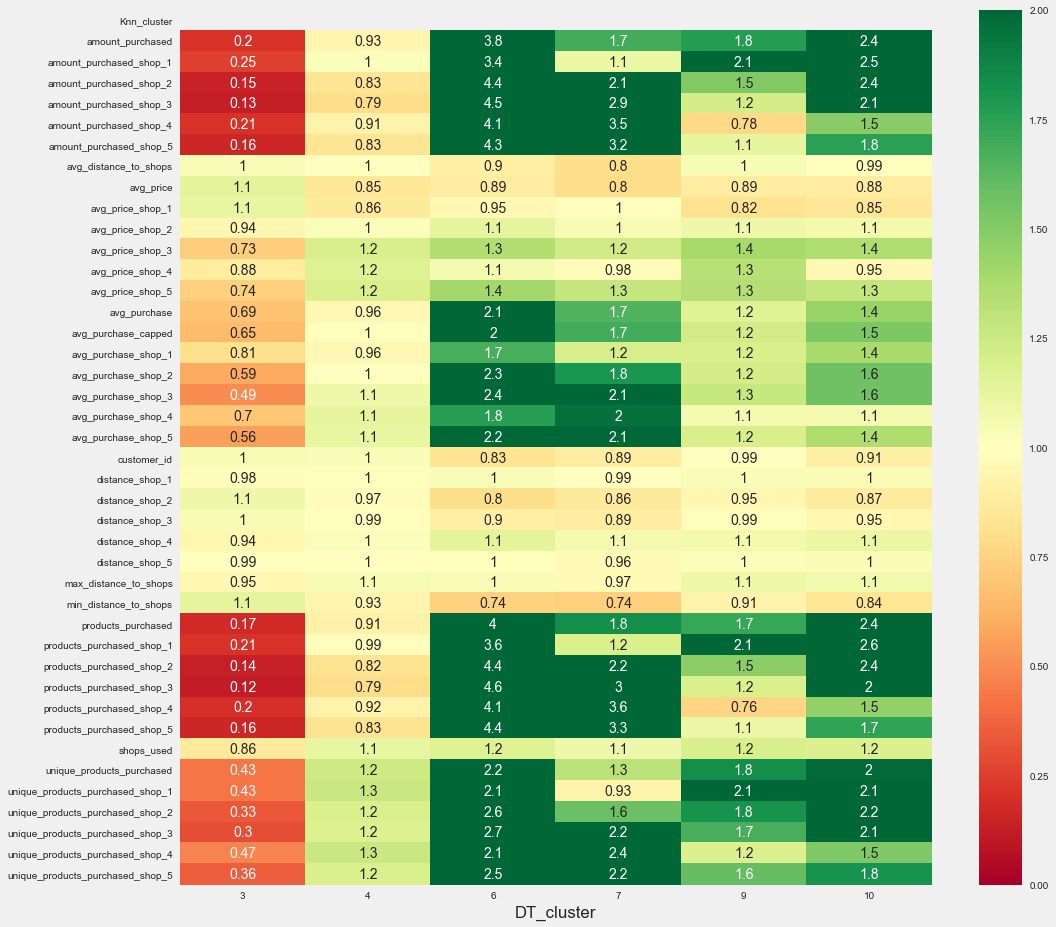

In [36]:
DT_table = data.groupby('DT_cluster').mean()
DT_norm_table = DT_table / field_means
DT_norm_table_transpose = DT_norm_table.transpose()
plt.figure(figsize=(15,15))
sns.heatmap(DT_norm_table_transpose, cmap='RdYlGn', annot=True, vmin=0, vmax=2)

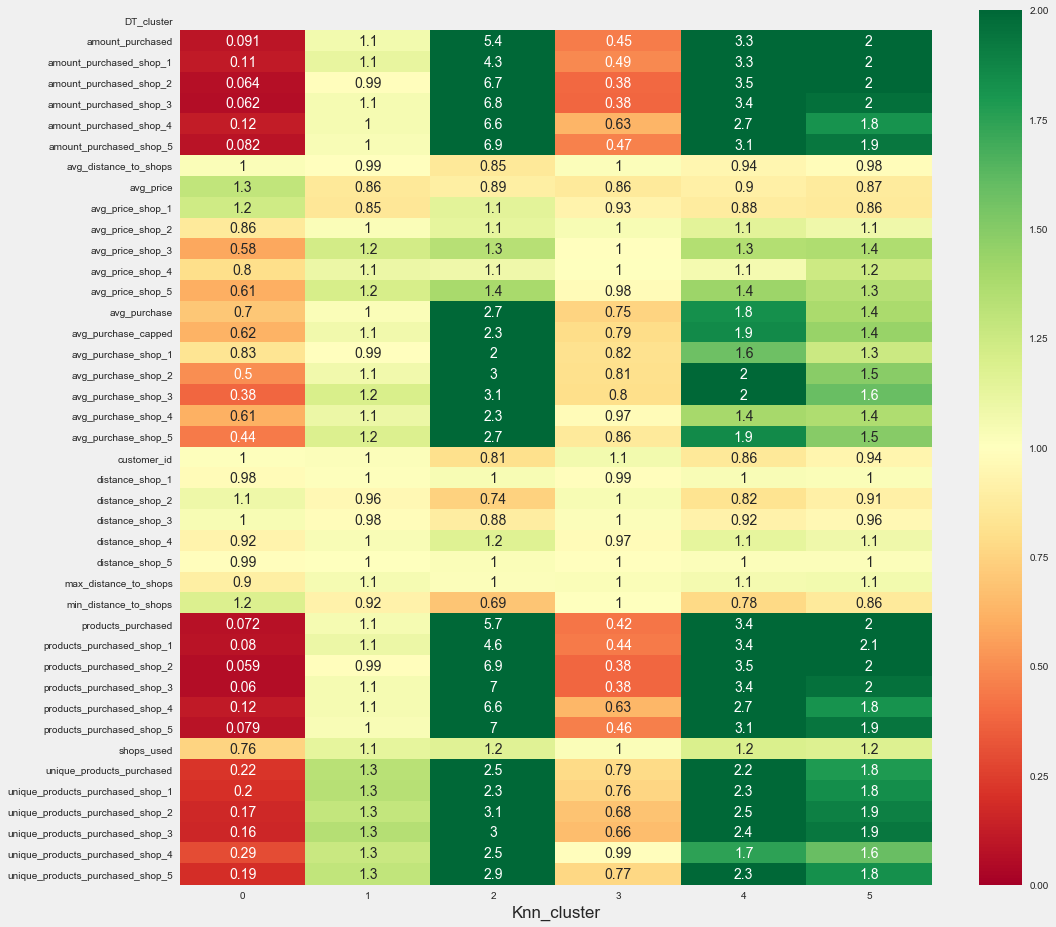

In [37]:
Knn_table = data.groupby('Knn_cluster').mean()
Knn_norm_table = Knn_table / field_means
Knn_norm_table_transpose = Knn_norm_table.transpose()
plt.figure(figsize=(15,15))
sns.heatmap(Knn_norm_table_transpose, cmap='RdYlGn', annot=True, vmin=0, vmax=2)

## Customer Value Measurement(CVM)

In [38]:
# Formulas:
# cvm = amtpurchase * f1 * f2 * f3
# f1 = 1 + (1.2 - 1) / (1+exp(-(mdts - mid[f1])/c))
# f2 = 1 + (1.3 - 1) / 1+exp(-(upp - mid[f2])/c))
# f3 = 1 + (1.4 - 1) / 1+exp(-(su - mid[f3])/c))

In [39]:
data['min_distance_to_shops'].describe(percentiles = [0.5,0.85,0.95])

count    60366.000000
mean      1396.414944
std       1048.422450
min          0.000000
50%       1184.943000
85%       2382.436200
95%       3420.848600
max       9004.164000
Name: min_distance_to_shops, dtype: float64

In [40]:
data['unique_products_purchased'].describe(percentiles = [0.5,0.85,0.95])

count    60366.000000
mean       330.662707
std        236.006225
min          0.000000
50%        304.000000
85%        599.000000
95%        752.000000
max       1465.000000
Name: unique_products_purchased, dtype: float64

In [41]:
data['shops_used'].describe(percentiles = [0.5,0.85,0.95])

count    60366.000000
mean         2.380015
std          1.012229
min          0.000000
50%          2.000000
85%          3.000000
95%          4.000000
max          5.000000
Name: shops_used, dtype: float64

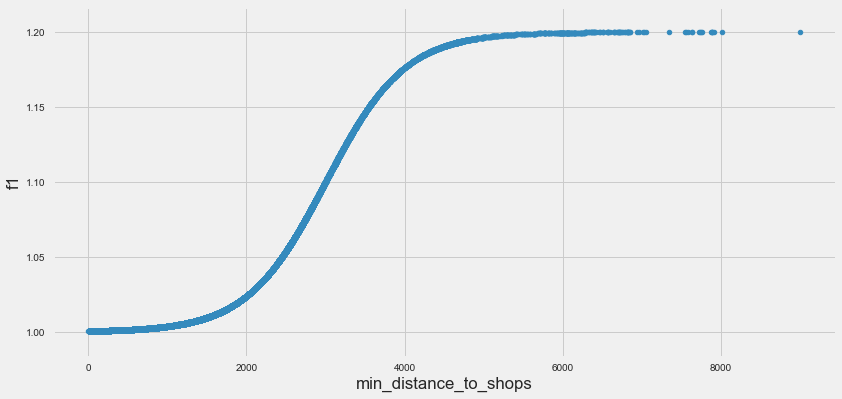

In [42]:
nmid_f1 = 3000
c_f1 = 500
data['f1'] = 1 + (1.2 -1) / (1+ np.exp(-(data['min_distance_to_shops'] - nmid_f1)/c_f1))
data.plot.scatter('min_distance_to_shops','f1')

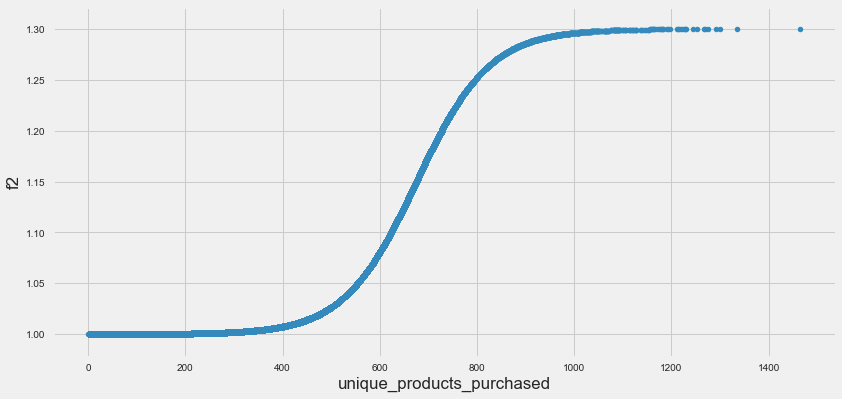

In [43]:
nmid_f2 = 675
c_f2 = 75
data['f2'] = 1 + (1.3 -1) / (1+ np.exp(-(data['unique_products_purchased'] - nmid_f2)/c_f2))
data.plot.scatter('unique_products_purchased','f2')

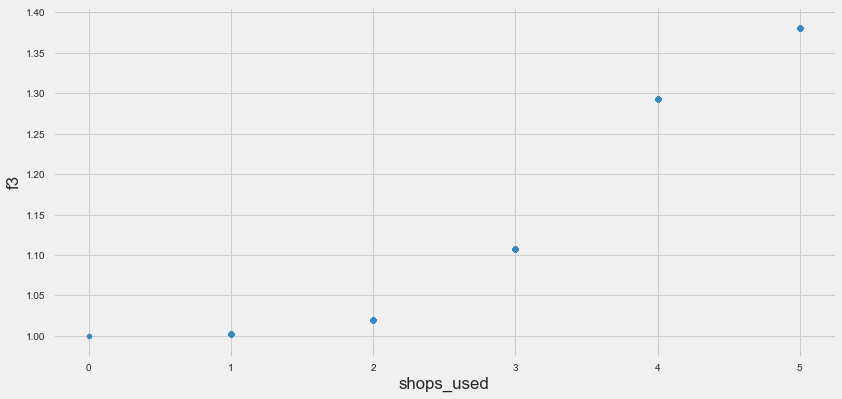

In [44]:
nmid_f3 = 3.5
c_f3 = .5
data['f3'] = 1 + (1.4 -1) / (1+ np.exp(-(data['shops_used'] - nmid_f3)/c_f3))
data.plot.scatter('shops_used','f3')

### Computing and Visualizing CVM

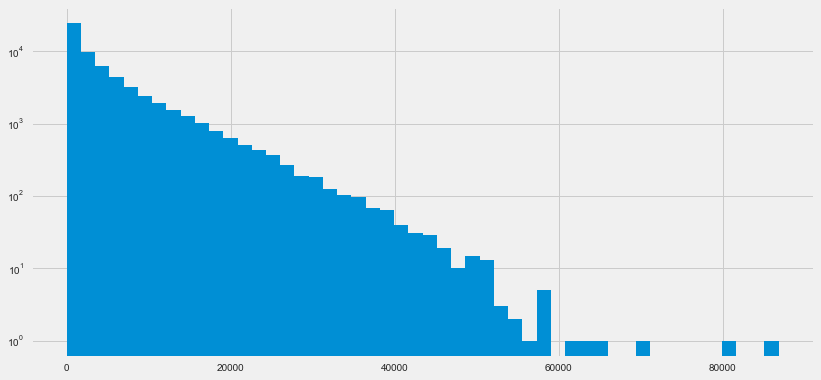

In [45]:
data['cvm'] = data['amount_purchased']*data['f1']*data['f2']*data['f3']
plt.hist(data['cvm'],bins = 50)
plt.yscale('log')

In [46]:
data.describe(percentiles=[0.5,0.85,0.95])

customer_id  avg_distance_to_shops  min_distance_to_shops  \
count  60366.000000           60366.000000           60366.000000   
mean   30183.500000            2030.193658            1396.414944   
std    17426.307512            1119.930918            1048.422450   
min        1.000000               0.000000               0.000000   
50%    30183.500000            1936.875950            1184.943000   
85%    51311.250000            2910.591150            2382.436200   
95%    57347.750000            4352.925625            3420.848600   
max    60366.000000            9004.164000            9004.164000   

       max_distance_to_shops  products_purchased  unique_products_purchased  \
count           60366.000000        60366.000000               60366.000000   
mean             2942.618832         1778.682918                 330.662707   
std              1327.571902         2185.044967                 236.006225   
min                 0.000000            0.000000                   0.000000   
50%              2869.195300          925.000000                 304.000000   
85%              4069.908700         3823.000000                 599.000000   
95%              5655.866700         6282.750000                 752.000000   
max              9267.698000        22131.000000                1465.000000   

       amount_purchased  avg_purchase     avg_price    shops_used  ...  \
count      60366.000000  60366.000000  60366.000000  60366.000000  ...   
mean        4235.423088      8.531965      3.666460      2.380015  ...   
std         5006.765288     10.315500      9.133185      1.012229  ...   
min            0.000000      0.000000      0.000000      0.000000  ...   
50%         2355.127000      6.862588      2.944260      2.000000  ...   
85%         8941.807000     13.018294      4.076573      3.000000  ...   
95%        14577.449000     18.776814      5.819828      4.000000  ...   
max        51588.656000    787.569000    787.569000      5.000000  ...   

       avg_price_shop_3  avg_price_shop_4  avg_price_shop_5  \
count      60366.000000      60366.000000      60366.000000   
mean           0.760319          0.444549          0.453596   
std            1.897947          4.385982          1.325875   
min            0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000   
85%            2.118578          1.534813          1.791640   
95%            2.480438          2.281587          2.297962   
max          263.234000        522.607000        133.967250   

       avg_purchase_capped    DT_cluster   Knn_cluster            f1  \
count         60366.000000  60366.000000  60366.000000  60366.000000   
mean              8.056039      4.470596      2.001011      1.023925   
std               4.633757      2.160331      1.804248      0.043031   
min               0.000000      3.000000      0.000000      1.000495   
50%               6.862588      3.000000      1.000000      1.005166   
85%              13.018294      7.000000      4.000000      1.045057   
95%              18.776814     10.000000      5.000000      1.139765   
max              20.000000     10.000000      5.000000      1.199999   

                 f2            f3           cvm  
count  60366.000000  60366.000000  60366.000000  
mean       1.034674      1.080410   5262.117867  
std        0.068786      0.103027   6856.250676  
min        1.000037      1.000364      0.000000  
50%        1.002117      1.018970   2615.533623  
85%        1.079898      1.107577  10989.235053  
95%        1.220881      1.292423  19579.471229  
max        1.299992      1.381030  86797.201172  

[8 rows x 47 columns]

In [51]:
# xhigh = 25000
# plt.hist(data['cvm'], bins = 50, edgecolor = 'blue')
# plt.yscale('log')
# plt.ylim(100,10000)
# plt.xlim(0,xhigh)
# plt.plot([2615,2615],[100,10000],"k-", linewidth = 4)
# plt.plot([10989,10989],[100,10000],"k-", linewidth = 4)
# plt.plot([19579,19579],[100,10000],"k-", linewidth = 4)
# plt.savefig('CVM DISTRIBUTION.png')

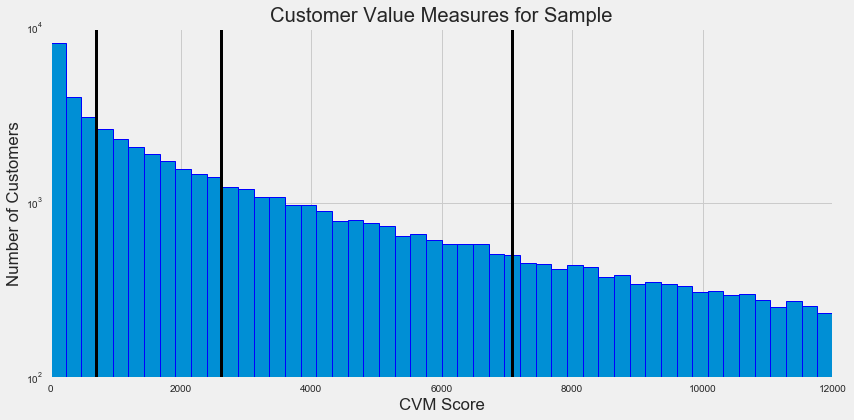

In [49]:
# Visualize CVM quartiles via histogram. 

xhigh = 12000
ylow = 100
yhigh = 10000

q1 = data['cvm'].describe().loc['25%']
q2 = data['cvm'].describe().loc['50%']
q3 = data['cvm'].describe().loc['75%']

# sns.set(font_scale=1.5)
temp = data[data['cvm']<xhigh]
plt.hist(temp['cvm'],bins=50,edgecolor='blue')
plt.yscale('log')
plt.ylim(ylow,yhigh)
plt.xlim(0,xhigh)
plt.plot([q1,q1],[ylow,yhigh],'k-',linewidth=3)
plt.plot([q2,q2],[ylow,yhigh],'k-',linewidth=3)
plt.plot([q3,q3],[ylow,yhigh],'k-',linewidth=3)
plt.title('Customer Value Measures for Sample')
plt.xlabel('CVM Score')
plt.ylabel('Number of Customers')

plt.savefig('CVM Distribution')

In [48]:
print('duration: ', datetime.now() - start_time)

duration:  0:01:34.871137
